<a href="https://colab.research.google.com/github/Harryte/Empty-Shelve-Detection-MS-Thesis/blob/main/Empty_space_detection_Open_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Empty space detection in Retail Shelves where there is no product present

### `Deepika Sharma`  ``||``                                      `Date : 26 Aug-01 Sept 2020`  ``||``   `Time Spent : 5 Days `  


**These problems are seemingly difficult to solve and I've personally known/experienced such problems where it took 3 months time to get a reasonable solution :)**

## Notebook Structure
**Appraoches**: 

- 1. OpenCV
        
    Images are segmented using Opencv Canny edge detection and contours are identified for blank spaces. Results are plotted in cell number 9.
- 2. YOLO
- 3. Mask RCNN
- 4. Custom appraoch
- Challanges, Way Forward

## `Problem # 1`

Given an image of Retail store shelf, identify sections where there is no product present. Make use of image libraries in python.. preferably OpenCV

### Methodology Using OpenCV

`Steps taken to get the empty space as foreground`

1. Reading images as numpy array using opencv.
2. Histogram based thresholding to seperate foreground and background.
3. Canny edge detection to find objects in the image.
4. Dilate and erode image with vertical and horizontal kernals to merge edges if too close.
5. Reverse the image to get empty space highlighted as 1's.
6. Co-ordinates detection using rectangle identification [rectangles of ones in the image] 

### Importing Libraries

In [ ]:
import cv2 #cv2  v4.2.0
import glob
import sys
import math
import csv,os
import random
import argparse
import skimage.io
import numpy as np

from scipy import ndimage #scipy v1.5.1
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max  #skimage v0.17.2
from skimage.segmentation import watershed

In [ ]:
import tensorflow
tensorflow.__version__

'2.12.0'

In [ ]:
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_doh
from keras.models import model_from_json  #keras v 2.1.5  default for Tensorflow 2.2.0

### Getting all the images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
retail_images_path = "/drive/MyDrive/MS/Object-detection-MRCNN-Yolo-master/retail_images/"

In [ ]:
CV2_Segmentation_path = "/drive/MyDrive/MS/Object-detection-MRCNN-Yolo-master/CV2_Segmentation/"

In [ ]:
os.listdir(os.getcwd() + retail_images_path)

['1.jpg',
 '2_.jpg',
 '4.jpg',
 '6.jpg',
 '5.jpg',
 '3.jpg',
 '7.jpg',
 '8.jpg',
 '2.jpg']

In [ ]:
os.mkdir(os.getcwd() + CV2_Segmentation_path)


FileExistsError: ignored

In [ ]:
os.listdir(os.getcwd() + CV2_Segmentation_path)

In [ ]:
images = os.listdir(os.getcwd() + retail_images_path)
images = images
escape=False

In [ ]:
# This function is to separate foreground vs background in a given image using opencv functionalities, Histogram based thresholding,
# Canny edge detection, followed by Dilation to join the edges followed by creating blobs and reversing the resultant image.

def get_foreground(img):
    '''
    input : img name
    output : Image with Blank space as foreground and rest as background
    '''
    h_kernel = np.ones((5,3),np.uint8)
    kernal = np.ones((3,3),np.uint8)
    if escape==True:
        cv2.destroyAllWindows()
#         break
    else:
        #Read the Image in color format
        color=cv2.imread(os.getcwd() + retail_images_path + img.split(".")[0]+".jpg")
#         color = cv2.resize(color, (780, 540),interpolation = cv2.INTER_NEAREST) 
        gray = cv2.cvtColor(color, cv2.COLOR_BGR2GRAY)
        
        #Threshold the image using Otsu
        ret3,th3 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

        # Create the minimum and maximum threshold values for Canny Edge detection
        hist_eq =cv2.equalizeHist(gray) #equqlising the histogram
        min_thresh=0.66*np.median(hist_eq)
        max_thresh=1.33*np.median(hist_eq)       

        edge_1 = cv2.Canny(gray,min_thresh,max_thresh)
        
        # Dilate the edges to make it more visible
        edge_2 = cv2.dilate(edge_1,None,iterations = 1)
        image_th_inv = cv2.bitwise_not(cv2.dilate(edge_2,h_kernel,iterations = 2))
        
    
    return image_th_inv,gray,ret3

In [ ]:
# This function combines the identified blobs using DoG (Difference of Gaussian)

def combine_bounding_boxes(upp_th,blob_list_sorted):
    '''
    upp_th  uppr threshold for bbx coordinates difference
    blob_list_sorted : Lsit of blobs whoch needs to be arranged to remove intersecting and overlapping bbx
    
    return : new bounding boxes list
    '''
    for i,val in enumerate(range(0,len(blob_list_sorted))):
        for j in range(i+1,len(blob_list_sorted)-2):
            if max(i,j) < len(blob_list_sorted) and max([abs(np.diff(x)) for x in zip(blob_list_sorted[j][0:2], blob_list_sorted[i][0:2])]) < upp_th:
                blob_list_sorted = blob_list_sorted+[[max(x) for x in zip(blob_list_sorted[j], blob_list_sorted[i])][0:2]+[blob_list_sorted[j][2]+blob_list_sorted[i][2]]]
                del blob_list_sorted[i]
                del blob_list_sorted[j]  
                len_val = len(blob_list_sorted)
    return blob_list_sorted

In [ ]:
def show_segmentation(img):
    '''
    input: image name
    output : Binarised image with empty space as 1's and products as 0's.
    
    '''
    
    original  = cv2.imread(os.getcwd() + retail_images_path + img.split(".")[0]+".jpg")    
    image_th_inv,gray,th = get_foreground(img)
#     upp_th = 4/(original.shape[0]*original.shape[0]); count = 1
  
    image_th_inv[image_th_inv > th] = 255
    image_th_inv[image_th_inv < th] = 0   
    _image = cv2.erode(image_th_inv,np.ones((3,3),np.uint8),iterations = 1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))#, sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(cv2.cvtColor(original,cv2.COLOR_RGB2BGR))
    ax[1].imshow(_image)
    
    plt.show()
    # cv2.imwrite("CV2_Segmentation/"+img, _image)# cv2.cvtColor(_image,cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.getcwd() + CV2_Segmentation_path +img, _image) 
    return _image

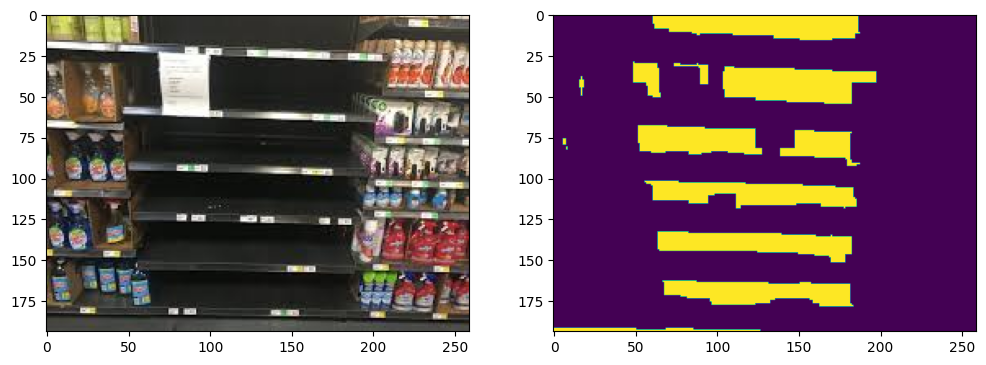

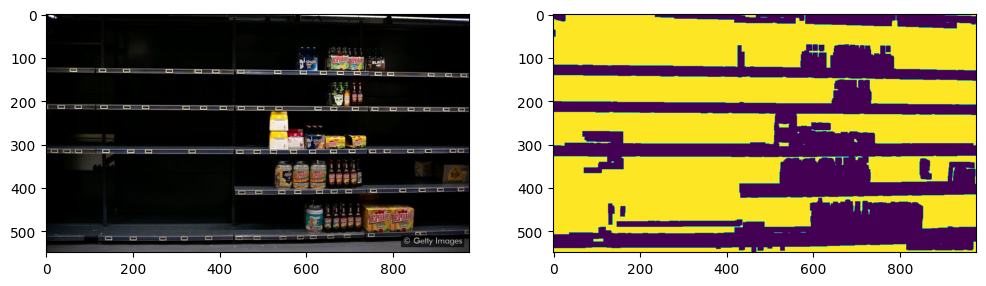

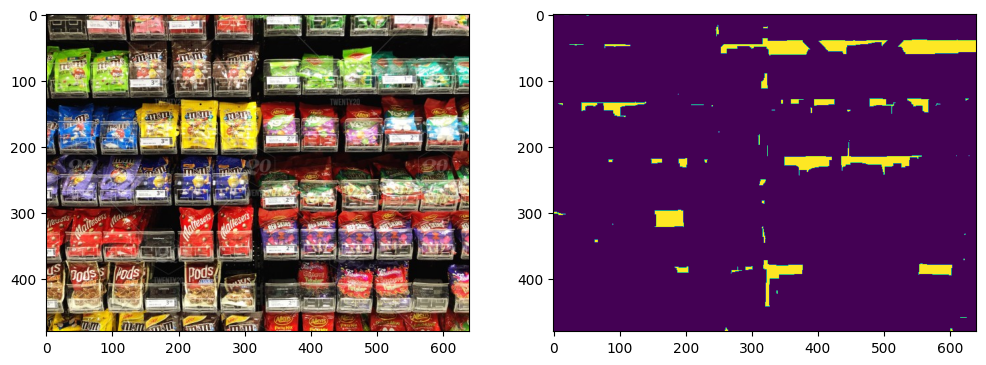

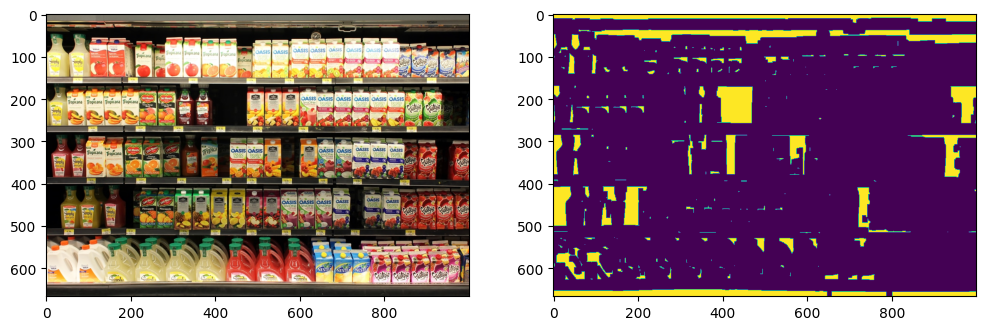

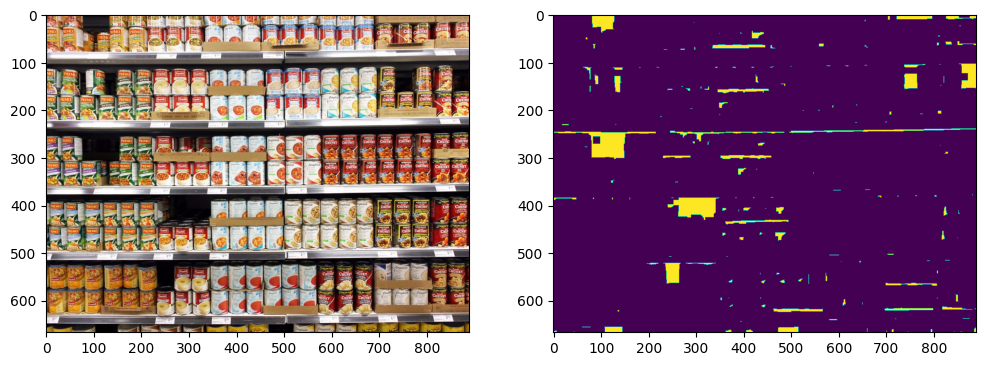

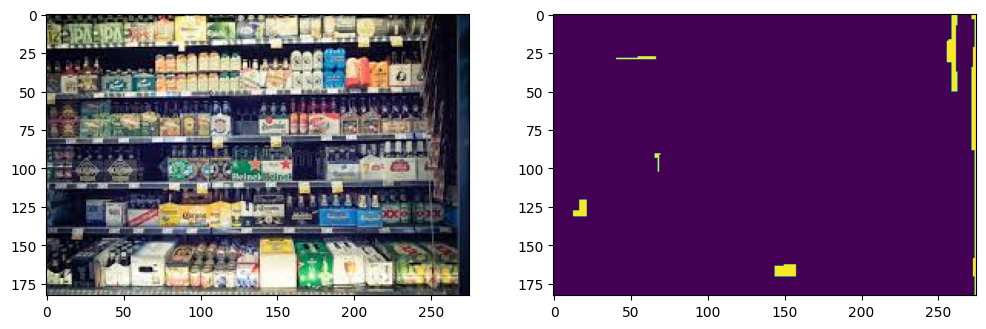

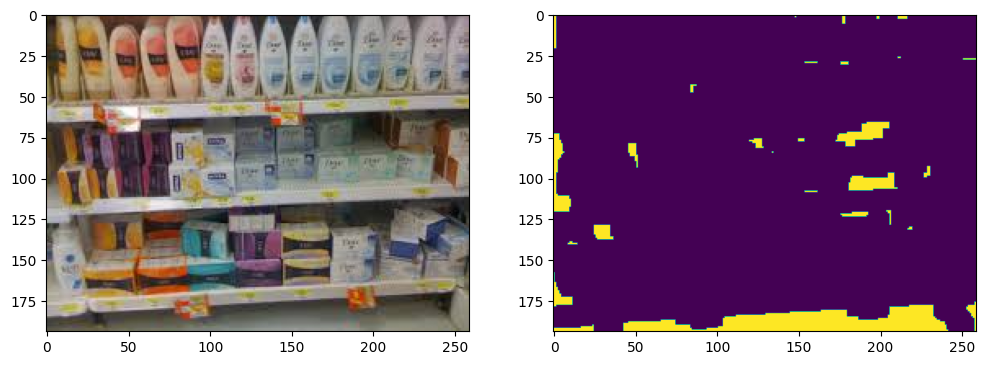

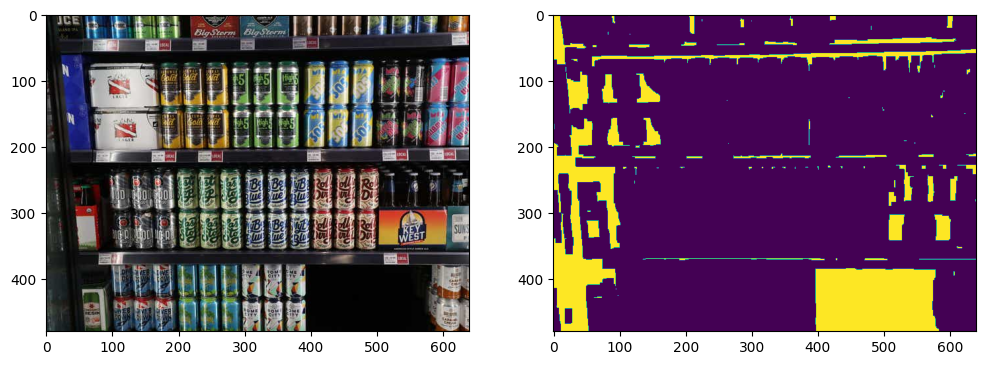

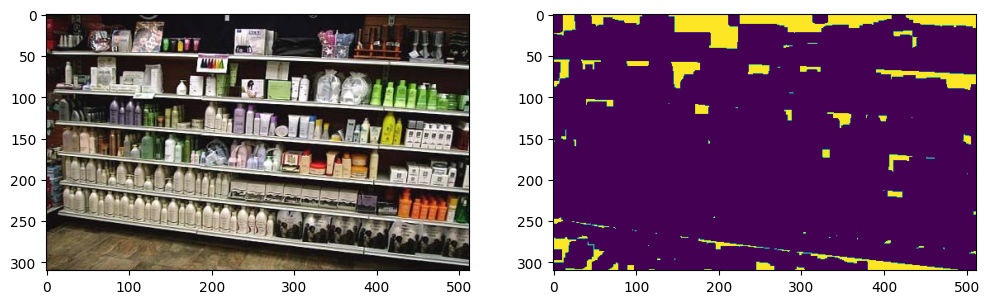

In [ ]:
for img in images:
  show_segmentation(img)

In [ ]:
import warnings
warnings.simplefilter("ignore")

results_cv2 = {"img_name" : [], "bbox" : [], "coords" : []}
filtered = []; contours_list = []; filtered_list = []; contours_ = []; contours_list_updated = []

# Main function #

def main(img):
    '''
    input: image name
    output : Bounding boxes for the empty space where there is no product present
    
    '''    
    
    original  = cv2.imread(os.getcwd() + retail_images_path + img.split(".")[0]+".jpg")
   
    upp_th = .00392; count = 0
    _image = cv2.imread(os.getcwd() + CV2_Segmentation_path + img.split(".")[0]+".jpg",0)
    
    blobs_dog = blob_dog(_image, max_sigma=40, threshold=.10)    
    blob_list_sorted = sorted([[int(blob[0]), int(blob[1]),int(blob[2])] for blob in blobs_dog])
    blob_list_sorted  = combine_bounding_boxes(upp_th,blob_list_sorted) 

    
    for blob in blob_list_sorted:
        y, x, r = blob
        if 6 < r :   
            original = cv2.rectangle(original,(int(x),int(y)),(int((x+r)),int((y+r))),(255,0,0),2)
            count = count+1
            results_cv2["img_name"].append(str(img.split(".")[0]))
            results_cv2["bbox"].append(count)
            results_cv2["coords"].append([x,y,x+r,y+r])
            
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))#, sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(original)
    
     # getting contours from segmented images
    contours, _ = cv2.findContours(_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    #Looping over all found contours
    objects = np.zeros([original.shape[0],original.shape[1],3], 'uint8')
    for c in contours:        
        #If it has significant area, add to list
        if cv2.contourArea(c) < (_image.shape[0]*_image.shape[1])*.10:#continue
            x = [val[0][0] for val in c]
            y = [val[0][1] for val in c] 
            filtered.append([x,y])
            contours_.append(c)
    
            cv2.drawContours(original,[c], -1, (255,0,0), -1)    
    
    ax[1].imshow(original)

    plt.show()
    cv2.imwrite("Identified_empty_spaces/"+img, original)# cv2.cvtColor(_image,cv2.COLOR_RGB2BGR))        
    return results_cv2,blob_list_sorted,filtered,contours_


In [ ]:
# main('1.jpg')

img = '1.jpg'

original  = cv2.imread(os.getcwd() + retail_images_path + img.split(".")[0]+".jpg")

# print(original)
   
upp_th = .00392; count = 0
_image = cv2.imread(os.getcwd() + CV2_Segmentation_path + img.split(".")[0]+".jpg",0)

print(_image)

blobs_dog = blob_dog(_image, max_sigma=40, threshold=.10)    
blob_list_sorted = sorted([[int(blob[0]), int(blob[1]),int(blob[2])] for blob in blobs_dog])
blob_list_sorted  = combine_bounding_boxes(upp_th,blob_list_sorted) 


# for blob in blob_list_sorted:
#     y, x, r = blob
#     if 6 < r :   
#         original = cv2.rectangle(original,(int(x),int(y)),(int((x+r)),int((y+r))),(255,0,0),2)
#         count = count+1
#         results_cv2["img_name"].append(str(img.split(".")[0]))
#         results_cv2["bbox"].append(count)
#         results_cv2["coords"].append([x,y,x+r,y+r])
        
# fig, axes = plt.subplots(1, 2, figsize=(15, 10))#, sharex=True, sharey=True)
# ax = axes.ravel()
# ax[0].imshow(original)

#   # getting contours from segmented images
# contours, _ = cv2.findContours(_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# #Looping over all found contours
# objects = np.zeros([original.shape[0],original.shape[1],3], 'uint8')
# for c in contours:        
#     #If it has significant area, add to list
#     if cv2.contourArea(c) < (_image.shape[0]*_image.shape[1])*.10:#continue
#         x = [val[0][0] for val in c]
#         y = [val[0][1] for val in c] 
#         filtered.append([x,y])
#         contours_.append(c)

#         cv2.drawContours(original,[c], -1, (255,0,0), -1)    

# ax[1].imshow(original)

# plt.show()
# cv2.imwrite("Identified_empty_spaces/"+img, original)# cv2.cvtColor(_image,cv2.COLOR_RGB2BGR))        


[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]]


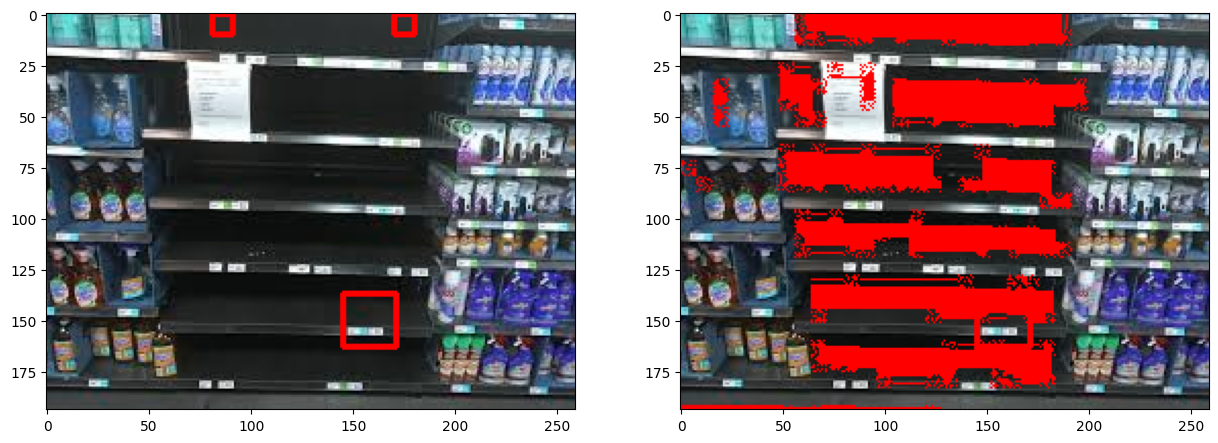

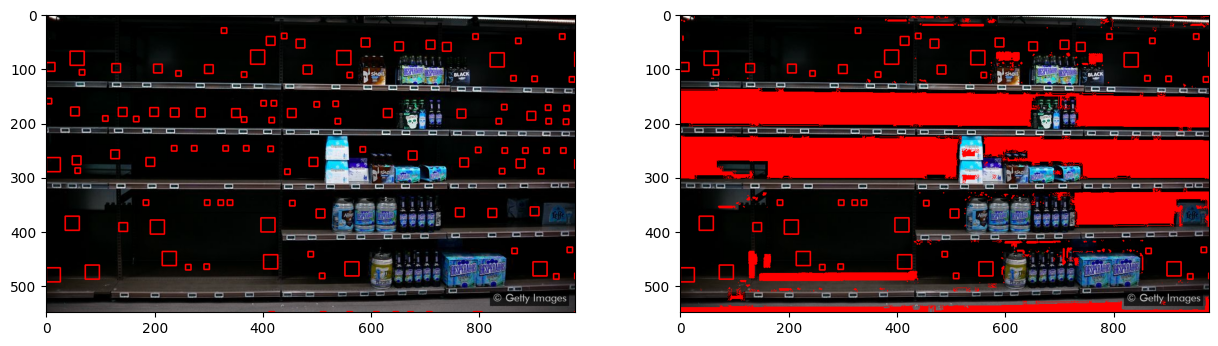

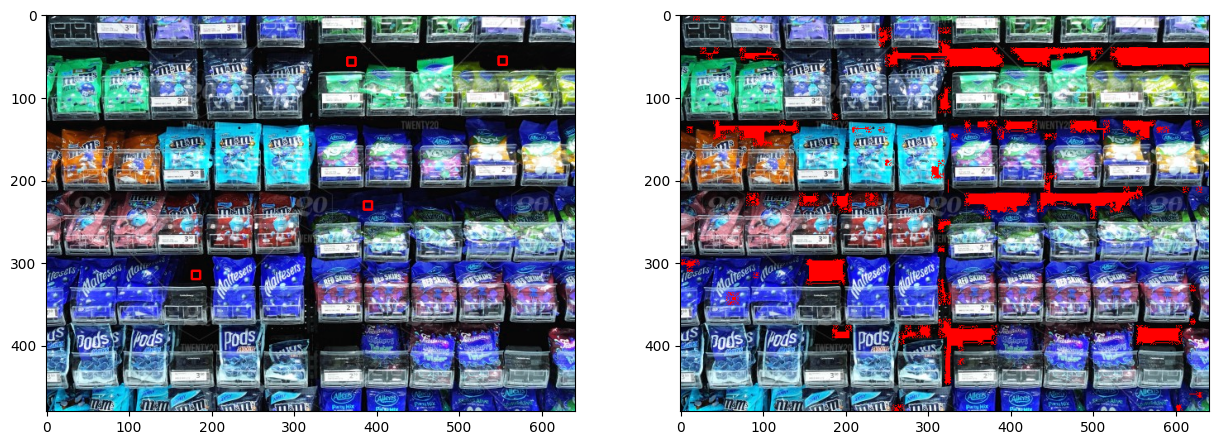

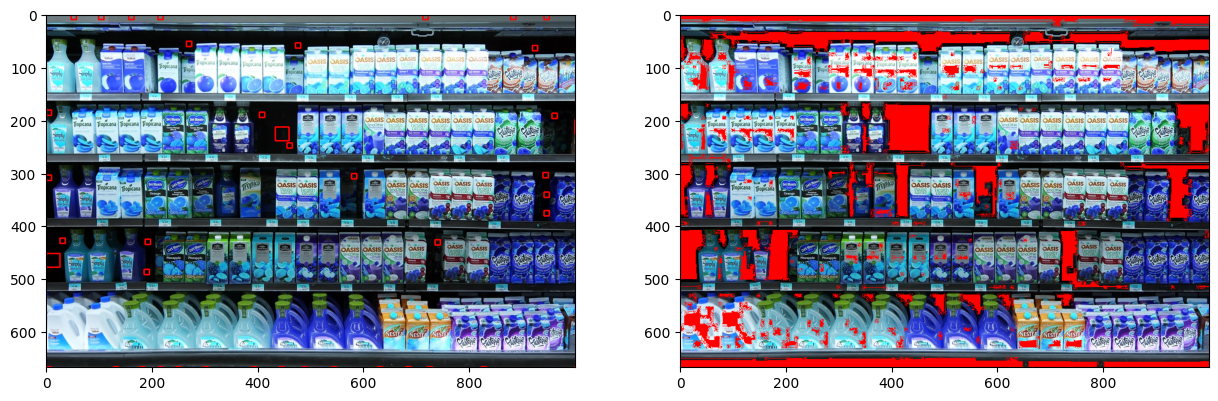

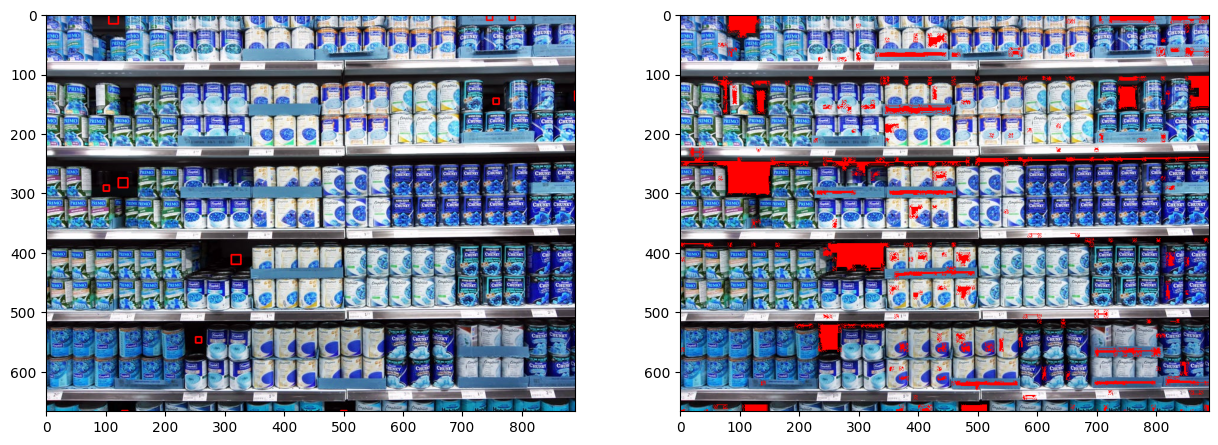

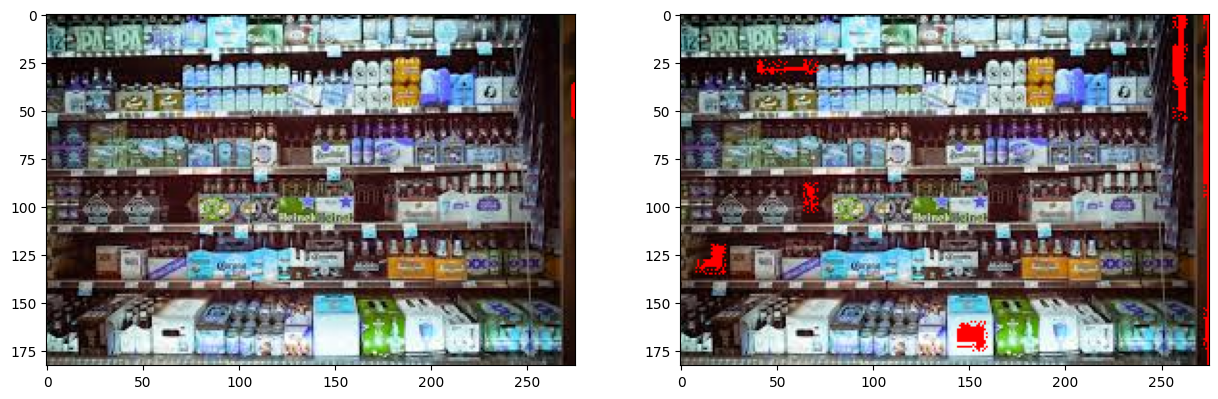

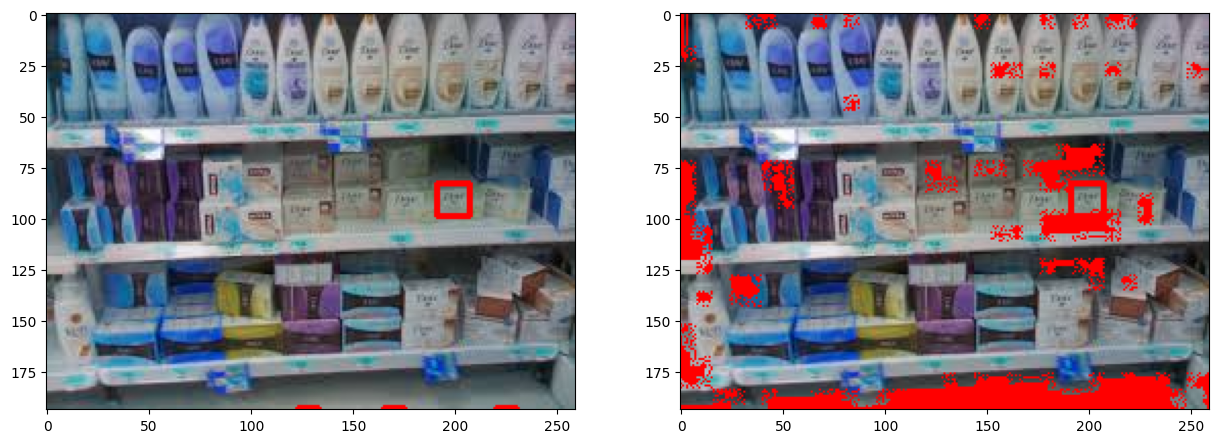

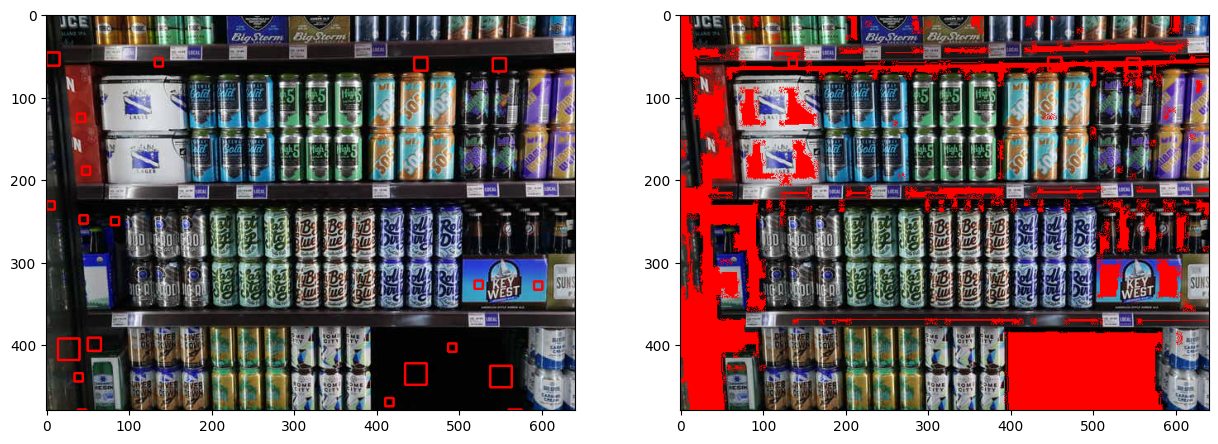

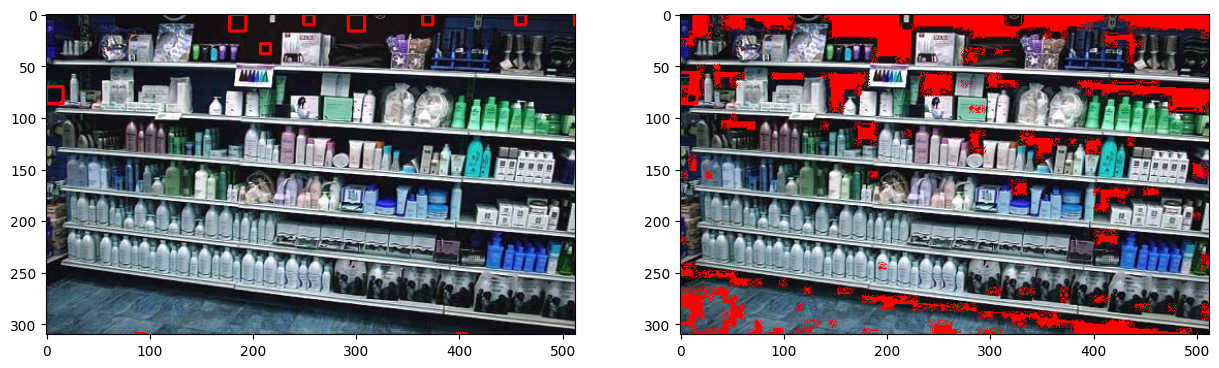

In [ ]:
## Show Bounding Boxes
for img in images:
    results_cv2,blob_list_sorted,filtered,contours_ = main(img) 
    filtered_list.append(filtered)
    contours_list_updated.append(contours_)

### Challanges using Open CV

- If in given image, products are placed behind each other then depth of the product is difficult to estimate using present algorithm and it is not able to pick if there is empty space in front of product which is placed in second row. It can be fixed using depth based filter.
- If there other objects in the image like floor, roof, human.. algorithms is failing to seperate the two using canny edge detection,,, which of course is not a right tool for seperating the objects.

`For separating objects, CascadeClassifier can be trained for various possible objects in the image for separating objects of interest vs other objects.`
- if product box contains black color logo which is very large or product box itself is black color, thresholding based approach tend to classify such objects as background. More adaptive ways to binarise the images is required.

### Improvements suggested

- ML model can be trained for adaptive thresholding, and learning various objects if data size is small.
- Multinomial Logistic Regression with gradient descent can be a choice, but only when data size is small and images are taken 
  under same context. for example, images of only one sku.
- To build a better solution which can generalise well, we will need Kernal based and Deep learning based approaches where we could also make use of transfer learning. 

## `Problem # 2`

`Solving the above problem with the mean of AI/ML based approaches.`

**Pls note, objective of the following approach is limited to solving the problem described. Deployment of the solution for real time detection and pushing notifications to the end user UI is beyond the scope of this notebook.**

Objective : Detection of blank spaces in the product shelves.

### 2.1 Testing YOLO

In [ ]:
pip install https://github.com/ayoolaolafenwa/yolo-opencv.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  ERROR: HTTP error 404 while getting https://github.com/ayoolaolafenwa/yolo-opencv.git
ERROR: Could not install requirement https://github.com/ayoolaolafenwa/yolo-opencv.git because of HTTP error 404 Client Error: Not Found for url: https://github.com/ayoolaolafenwa/yolo-opencv for URL https://github.com/ayoolaolafenwa/yolo-opencv.git


In [ ]:
!pip install opencv-python
!pip install opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!wget https://github.com/AlexeyAB/darknet/raw/master/cfg/yolov3.cfg
!wget https://github.com/AlexeyAB/darknet/raw/master/yolov3.weights
!wget https://github.com/AlexeyAB/darknet/raw/master/data/coco.names

--2023-05-29 13:41:37--  https://github.com/AlexeyAB/darknet/raw/master/cfg/yolov3.cfg
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov3.cfg [following]
--2023-05-29 13:41:37--  https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2023-05-29 13:41:37 (78.0 MB/s) - ‘yolov3.cfg’ saved [8342/8342]

--2023-05-29 13:41:37--  https://github.com/AlexeyAB/darknet/raw/master/y

In [ ]:
from yolo_opencv import YOLO

ModuleNotFoundError: ignored

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone

Cloning into 'yolov5'...
remote: Enumerating objects: 15731, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 15731 (delta 25), reused 32 (delta 18), pack-reused 15672
Receiving objects: 100% (15731/15731), 14.57 MiB | 20.08 MiB/s, done.
Resolving deltas: 100% (10766/10766), done.


In [ ]:
cd yolov5

/content/yolov5


In [ ]:
pip install -r requirements.txt  # install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.7/592.7 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00


In [ ]:
import yolo_opencv

In [ ]:
import yolo_opencv
def yolo_(img):
    image_yolo,boxes = yolo_opencv.get_bounding_boxes(img)
    fig, axes = plt.subplots(1, 2, figsize=(20, 12))#, sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(cv2.imread("retail_images/" + img.split(".")[0]+".jpg"))
    ax[1].imshow(image_yolo)

    plt.show()
    return boxes


In [ ]:
# This function removes coordinates of bboxes identified by OpenCV intersecting with bbox of Yolo identifed objects.

bbox_list = [] 
def get_bbox_intersection(img,boxes_1,idx_):
    id_list = [idx for idx,val in enumerate(results_cv2["img_name"]) if val == img.split(".")[0]]
    boxes_0 = results_cv2["coords"][min(id_list):max(id_list)+1] # getting boxes identified by cv2 for "img"
        
    
    for val in boxes_0: #iterating over boxes
        check_ = [val for val1_ in boxes_1 if (val[0] <= val1_[0] or val[0] <= val1_[0]+val1_[2]) and (val[1] <= val1_[1] or val[1] <= val1_[1]+val1_[3]) and (val[2]-val[0])*(val[3]-val[1]) <= (val1_[2])*(val1_[3])]
        if len(check_) > 0:
            idx = boxes_0.index([list(x) for x in set(tuple(x) for x in check_)][0])
            del boxes_0[idx]
            
    bbox_list.append(boxes_0)
    
    
    for element in  filtered_list: #iterating over boxes        
        def IoU(val,val1_):
            
            s1 = set(list(range(int(val1_[0]),int(val1_[0])+int(val1_[2]))))
            s2 = set(list(range(int(val1_[1]),int(val1_[1])+int(val1_[3]))))
        
            l_1 = len(set(val[0]).intersection(s1))/max(len(val[0]),len(s1))
            l_2 = len(set(val[1]).intersection(s2))/max(len(val[1]),len(s2))

            return l_1+l_2
        
        check_list = []
        for i,val in enumerate(element):
            if len([val for val1_ in boxes_1 if IoU(val,val1_) > .40]) > 0:
                check_list.append(i)
        
        bbox_list_contour = []
        if len(check_list) > 0:
#             print(len([val for i,val in enumerate(element) if i not in check_list]),len(element))
            bbox_list_contour.append([val for i,val in enumerate(contours_list_updated[idx_]) if i not in check_list])
            
    return bbox_list,bbox_list_contour

In [ ]:
bbox_list_contour_append = []
for idx_,img in enumerate(images):
    boxes_1= yolo_(img)
    bbox_list,bbox_list_contour = get_bbox_intersection(img,boxes_1,idx_)
    bbox_list_contour_append.append(bbox_list_contour)

NameError: ignored

###  Results using CV2 contours on segmented images vs Results using blob detection on segmeted images
`Note : Both the bounding boxes are filtered using objects identified by Yolo to remove any bounding box identfied on an object, if there are any`.

In [ ]:
for i,img in enumerate(images):
    original  = cv2.imread(os.getcwd() + "/retail_images/" + img.split(".")[0]+".jpg")
    boxes = bbox_list[i]
    for box_ in boxes: 
        try:
            x = box_[0]
            y = box_[1]
            z = box_[2]
            p = box_[3]
            original = cv2.rectangle(original,(int(x),int(y)),(int(z),int(p)),(255,0,0),2)
        except:pass
    
    original_  = cv2.imread(os.getcwd() + "/CV2_Segmentation/" + img.split(".")[0]+".jpg")
    
    objects = np.zeros([original.shape[0],original.shape[1],3], 'uint8')
    
#     print(boxes)
    #Looping over filtered contours
    if len(bbox_list_contour_append[i]) > 0:
        boxes = bbox_list_contour_append[i][0]
        for c in boxes:
#             c_ = np.array([[val,c[1][i]] for i,val in enumerate(c[0])])
            #Draw the contour on the image with above color
            cv2.drawContours(original_,[c], -1, (0,0,255), -1)


    fig, axes = plt.subplots(1, 2, figsize=(20, 12))#, sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(original_)
    ax[1].imshow(original)

    plt.show()

NameError: ignored

As we can see, using CV2 Contours on segmented images, we are getting far too many flase positives. However blob detection seem to be providing way better results, as bounding boxes are least intersecting with objects in an image.

### 2.2 Testing Mask RCNN

In [ ]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from coco import coco as coco_
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version


%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(os.getcwd(), "retail_images")

### Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [ ]:
class InferenceConfig(coco_.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

### Create Model and Load Trained Weights

In [ ]:
import warnings
warnings.simplefilter("ignore")
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
# from keras.models
model.load_weights(COCO_MODEL_PATH, by_name=True)

### Class Names

In [ ]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [ ]:
# This function removes coordinates of bboxes identified by OpenCV+OpenCV intersecting with bbox for objects identifed by MCRNN.
bbox_list_mrcnn=[]
def get_bbox_intersection_(img,boxes_1):
    boxes_0 = bbox_list[images.index(img)]
    
    for val in boxes_0:
        check_ = [val for val1_ in boxes_1 if (val[0] <= val1_[0] or val[0] <= val1_[0]+val1_[2]) and (val[1] <= val1_[1] or val[1] <= val1_[1]+val1_[3]) and (val[2]-val[0])*(val[3]-val[1]) <= (val1_[2])*(val1_[3])]
        if len(check_) > 0:
            idx = boxes_0.index([list(x) for x in set(tuple(x) for x in check_)][0])
            del boxes_0[idx]
    
    bbox_list_mrcnn.append(boxes_0)
    return bbox_list_mrcnn

### Run Object Detection

In [ ]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
for img in images:
    image = skimage.io.imread(os.path.join(IMAGE_DIR, img))#random.choice(file_names)
    # Run detection
    # import tensorflow
    with tensorflow.compat.v1.Session() as sess:
        model.load_weights(COCO_MODEL_PATH, by_name=True)
        results = model.detect([image], verbose=1)
        boxes_1 = results[0]["rois"]
#         print(boxes_1)
        boxes_1 = [val for val in boxes_1 if ((val[2]-val[0])*(val[3]-val[1])) < image.shape[0]*image.shape[1]*.30]
        bbox_list_mrcnn = get_bbox_intersection_(img,results[0]["rois"])
        # Visualize results
        r = results[0]
        visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                    class_names, r['scores'])

In [ ]:
# Images with filtered bounding boxes identified for blank/void spaces in shelf images
for i,img in enumerate(images):
    original  = cv2.imread(os.getcwd() + "/retail_images/" + img.split(".")[0]+".jpg")
    boxes = bbox_list_mrcnn[i]
    for box_ in boxes: 
        try:
            x = box_[0]
            y = box_[1]
            z = box_[2]
            p = box_[3]
            original = cv2.rectangle(original,(int(x),int(y)),(int(z),int(p)),(255,0,0),2)
        except:pass


    fig, axes = plt.subplots(1, 2, figsize=(20, 12))#, sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(cv2.imread("retail_images/" + img.split(".")[0]+".jpg"))
    ax[1].imshow(original)

    plt.show()

## Challanges involved in solving this problem

- Yolo is not able to identify all the objects in an Image, but false positives are very less, so we can be sure the object
yolo has detected, that can not be a blank/void space.


- Mask RCNN is able to pick up almost all the objects in an image, but there are false positives. 


- Tried coordinates combination, coordinates from OpenCV, YOLO, MaskRCNN, but detection of blank/vid space which is highly dependent on the correct detection of rest of the objects in the image.  



Following are few scenarios where most challanges occured:

`Scenario 1:` Idenfication of blank spaces where there is no product present, such spaces are mostly in middle of the retail shelves and for identification, it will require a lot of contexual information to segregate objects from blank spaces.

`Scenario 2:` If image is warped or has angle, then pixel depth information will not be useful in identifying features for blank/void space.

`Scenario 3:` Different light conditions will bias the information.

`Scenario 4:` Images with lot of surrounding information like roof, floor, different other objects placed near shelves will add error in the prediction.

`Scenario 5:` Images with clear frames and only has images of shelf products are best suited for model training.

`Scenario 6:` Images with various size items in the shelf adding challanges in finding true reference for the blank/void space in the shelf.

`Scenario 7:` If shelves have different patterns in their designs which are mixing well the design on product box/es, algorihtm will fail to identify if space found truly has a product there or not.

`Scenario 8:` If shelves color is same as products' box color, for ex, milk boxes placed in a white shelf will not be picked as objects when using canny edge detection after tresholding the image.

### Note:

1. OpenCV is doing a fair job in segmenting blank space but in detection results are not good.
2. Combining coordinates of OpenCV DoG and Yolo are doing relatively best job, agree there is a lot to improve.
3. Combining coordinates of OpenCV DoG, Yolo and MaskRCNN is not benefiting additionaly.
4. MaskRCNN is doing a great work in detecting objects, however recognition accuracy is less.
5. Yolo does seem to be doing a fair job, high quality images are required for yolo to work best where products are palced at distance from each other.


### Data requirement:
**a.** Annotated data which has bounding boxes for void/blank spaces where no product is placed.

**b.** Corresponding names of all possible classes under which shelf products can possibly fall.
` This information will be required for machine to automatically identify relative dimensions and specifications for blank/void space.`


**c.** Data across various departments for better generalisation.


### Hardware requirement:

A GPU or i7/i9 processor base CPU for model training.

### Model Choices/Approaches:

**1.** Transfer Learning : Train a VGG 16/19/UNet or sliding window deep learning models RCNN using respective architectures to only train last few layers on annotated data if context in the images is almost constant. 

`This means training separate models for diiferent SKUs will serve the purpose.`

**2.** The other approach will be to shallow train YOLO/Imagenet which are pre-trained models for identifying objects in different contexts and use complement of bboxes to find empty/blank spaces in retail shelves.






Look forward to next post! Happy coding.